# LangGraph Manual State Update

LangGraph cung cấp một cách để **manually update the intermediate state** (cập nhật thủ công trạng thái trung gian).

Bằng cách cập nhật trạng thái, bạn có thể **control the path by modifying the agent's behavior** (kiểm soát đường đi bằng cách sửa đổi hành vi của agent) và thậm chí sửa đổi quá khứ.

Tính năng này đặc biệt hữu ích để **correcting the agent's mistakes** (sửa lỗi của agent), **exploring alternative routes** (khám phá các tuyến đường thay thế) hoặc **modifying the agent's behavior** (sửa đổi hành vi của agent) theo một mục tiêu cụ thể.

- Lưu ý: Agent được sử dụng trong hướng dẫn này định nghĩa cùng một graph như hướng dẫn trước.


In [1]:
import os
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict

from langchain_ollama import ChatOllama
# from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import TavilySearchResults

load_dotenv(dotenv_path='../.env')

###### Define the State ######
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


###### Define the tool and binding ######
tool = TavilySearchResults(
    max_results=3,
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # search_depth="advanced",
    # include_domains = []
    # exclude_domains = []
)


tools = [tool]
llm = ChatOllama(model='qwen2.5:7b', temperature=0)
llm_with_tools = llm.bind_tools(tools)


###### Add Nodes ######
def chatbot(state: State):
    """
    Invoke the message and return the result.
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# chatbot node
graph_builder.add_node("chatbot", chatbot)

# tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# conditional edge
graph_builder.add_conditional_edges("chatbot", tools_condition)


###### Add Edges ######
# tools -> chatbot
graph_builder.add_edge("tools", "chatbot")

# START -> chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot -> END
graph_builder.add_edge("chatbot", END)


###### Add the MemorySaver ######
memory = MemorySaver()

In [2]:
graph = graph_builder.compile(checkpointer=memory)

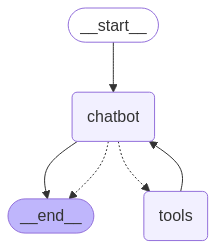

In [3]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the graph
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [4]:
from langchain_core.runnables import RunnableConfig

question = "Vui lòng tìm hiểu và cập nhật thông tin giá vàng mới nhất."

input = State(messages=[("user", question)])

config = RunnableConfig(
    configurable={'thread_id': '1'}
)

In [5]:
# Display list graph channels
list(graph.channels)

['messages',
 '__start__',
 'chatbot',
 'tools',
 'branch:__start__:__self__:chatbot',
 'branch:__start__:__self__:tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:tools']

In [6]:
# Call graph stream

events = graph.stream(
    input=input, config=config, interrupt_before=["tools"], stream_mode='values'
)

In [7]:
for event in events:
    if 'messages' in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Vui lòng tìm hiểu và cập nhật thông tin giá vàng mới nhất.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (114c7bba-7d2a-4950-8136-8786ea77afca)
 Call ID: 114c7bba-7d2a-4950-8136-8786ea77afca
  Args:
    query: giá vàng mới nhất


Bước hiện tại bị gián đoạn bởi `ToolNode`.

Kiểm tra tin nhắn gần đây nhất để thấy rằng `ToolNode` chứa `query` trước khi thực hiện tìm kiếm.

Ở đây, `query` chỉ chứa từ `LangGraph`. (Câu hỏi ban đầu là `"Please research and tell me what LangGraph is!"`)

Tất nhiên, kết quả tìm kiếm trên web có thể không phải là thứ chúng ta muốn.


In [13]:
import json

# Custom function to serialize non-JSON serializable objects
def custom_serializer(obj):
    if hasattr(obj, "__dict__"):
        return obj.__dict__
    elif isinstance(obj, (list, tuple)):
        return [custom_serializer(item) for item in obj]
    return str(obj)


# Custom function to print the snapshot
def pretty_print_snapshot(snapshot):
    try:
        snapshot_json = json.dumps(
            snapshot, indent=4, ensure_ascii=False, default=custom_serializer
        )
        print(snapshot_json)
    except Exception as e:
        print(f"Error formatting snapshot: {e}")

In [14]:
snapshot = graph.get_state(config)
last_message = snapshot.values["messages"][-1]
last_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (114c7bba-7d2a-4950-8136-8786ea77afca)
 Call ID: 114c7bba-7d2a-4950-8136-8786ea77afca
  Args:
    query: giá vàng mới nhất


## Human in the loop

- Sửa đổi **search result** (kết quả tìm kiếm) từ công cụ `TavilySearch`

Chúng ta thường thấy rằng kết quả của `ToolMessage` không đạt yêu cầu.

Đặc biệt, câu trả lời thu được từ tìm kiếm trên web có thể chứa thông tin không chính xác, điều này cũng có thể ảnh hưởng đến câu trả lời của chatbot.

Nếu bạn muốn sửa đổi `ToolMessage` từ `Tavily Tool` và chuyển nó cho LLM, bạn có thể làm điều đó như thế nào?


![](../images/07-langgraph-manual-state-update.png)

In [15]:
modified_search_result = """[Modified web search result] 
Đồng đôla mạnh lên và hoạt động bán chốt lời khiến giá vàng thế giới mất hơn 20 USD phiên cuối tuần.

Chốt phiên giao dịch 21/3, giá vàng thế giới giao ngay giảm 20 USD xuống 3.023 USD một ounce. Trong phiên, giá có thời điểm về 2.996 USD - thấp nhất 1 tuần qua.

Thị trường đi xuống do đồng đôla mạnh lên và nhà đầu tư bán chốt lời, bất chấp căng thẳng kinh tế - chính trị vẫn tiếp diễn. Khả năng Cục Dự trữ liên bang Mỹ (Fed) giảm lãi suất năm nay cũng giúp vàng ghi nhận tuần tăng thứ 3 liên tiếp, với 1%.
Xem chi tiết hơn tại https://vnexpress.net/gia-vang-the-gioi-giam-manh-4864424.html"""

print(modified_search_result)

[Modified web search result] 
Đồng đôla mạnh lên và hoạt động bán chốt lời khiến giá vàng thế giới mất hơn 20 USD phiên cuối tuần.

Chốt phiên giao dịch 21/3, giá vàng thế giới giao ngay giảm 20 USD xuống 3.023 USD một ounce. Trong phiên, giá có thời điểm về 2.996 USD - thấp nhất 1 tuần qua.

Thị trường đi xuống do đồng đôla mạnh lên và nhà đầu tư bán chốt lời, bất chấp căng thẳng kinh tế - chính trị vẫn tiếp diễn. Khả năng Cục Dự trữ liên bang Mỹ (Fed) giảm lãi suất năm nay cũng giúp vàng ghi nhận tuần tăng thứ 3 liên tiếp, với 1%.
Xem chi tiết hơn tại https://vnexpress.net/gia-vang-the-gioi-giam-manh-4864424.html


Next, inject the modified search result into the `ToolMessage`. 

**Important**

- To modify the message, you need to specify the `tool_call_id` that matches the message you want to modify.

In [16]:
tool_call_id = last_message.tool_calls[0]["id"]
print(f"{tool_call_id=}")

tool_call_id='114c7bba-7d2a-4950-8136-8786ea77afca'


In [ ]:
from langchain_core.messages import AIMessage, ToolMessage

new_messages = [
    ToolMessage(
        content=modified_search_result,
        tool_call_id=tool_call_id
    ),
    # Add content directly to the LLM's response
    # AIMessage(content=modified_search_result),
]
new_messages[-1].pretty_print()

================================= Tool Message =================================

[Modified web search result] 
Đồng đôla mạnh lên và hoạt động bán chốt lời khiến giá vàng thế giới mất hơn 20 USD phiên cuối tuần.

Chốt phiên giao dịch 21/3, giá vàng thế giới giao ngay giảm 20 USD xuống 3.023 USD một ounce. Trong phiên, giá có thời điểm về 2.996 USD - thấp nhất 1 tuần qua.

Thị trường đi xuống do đồng đôla mạnh lên và nhà đầu tư bán chốt lời, bất chấp căng thẳng kinh tế - chính trị vẫn tiếp diễn. Khả năng Cục Dự trữ liên bang Mỹ (Fed) giảm lãi suất năm nay cũng giúp vàng ghi nhận tuần tăng thứ 3 liên tiếp, với 1%.
Xem chi tiết hơn tại https://vnexpress.net/gia-vang-the-gioi-giam-manh-4864424.html


### StateGraph's `update_state` Method

Phương thức `update_state` cập nhật trạng thái của đồ thị với các giá trị được cung cấp. Phương thức này hoạt động như thể các giá trị xuất phát từ `as_node`.

**Tham số**

- `config` (RunnableConfig): Cấu hình thực thi
- `values` (Optional[Union[dict[str, Any], Any]]): Các giá trị cần cập nhật
- `as_node` (Optional[str]): Tên node được xem là nguồn gốc của các giá trị. Giá trị mặc định là None

**Trả về**

- RunnableConfig

**Các tính năng chính**

1. Tải trạng thái trước đó thông qua checkpoint và lưu trạng thái mới.
2. Xử lý cập nhật trạng thái cho subgraph.
3. Nếu `as_node` không được chỉ định, tìm node đã cập nhật trạng thái cuối cùng.
4. Cập nhật trạng thái bằng cách sử dụng writers của node được chỉ định.
5. Lưu trạng thái đã cập nhật vào checkpoint.

**Logic chính**

1. Kiểm tra checkpoint và đưa ra lỗi ValueError nếu không tìm thấy.
2. Nếu cập nhật cho subgraph, gọi phương thức `update_state` của subgraph.
3. Tải checkpoint trước đó và xác định `as_node` nếu cần thiết.
4. Cập nhật trạng thái bằng cách sử dụng writers của node được chỉ định.
5. Lưu trạng thái đã cập nhật vào checkpoint mới.

**Lưu ý**

- Phương thức này được sử dụng khi cập nhật trạng thái của đồ thị một cách thủ công. 
- Sử dụng checkpoint để đảm bảo quản lý phiên bản và tính bền vững của trạng thái.
- `as_node` được xác định tự động, nhưng nếu không rõ ràng, có thể xảy ra lỗi.
- Việc ghi vào SharedValues không được phép trong quá trình cập nhật trạng thái.


In [18]:
graph.update_state(
    config,
    {"messages": new_messages},
    as_node="tools"
)
print("(Display the most recent message)\n")
print(graph.get_state(config).values["messages"][-1])

(Display the most recent message)

content='[Modified web search result] \nĐồng đôla mạnh lên và hoạt động bán chốt lời khiến giá vàng thế giới mất hơn 20 USD phiên cuối tuần.\n\nChốt phiên giao dịch 21/3, giá vàng thế giới giao ngay giảm 20 USD xuống 3.023 USD một ounce. Trong phiên, giá có thời điểm về 2.996 USD - thấp nhất 1 tuần qua.\n\nThị trường đi xuống do đồng đôla mạnh lên và nhà đầu tư bán chốt lời, bất chấp căng thẳng kinh tế - chính trị vẫn tiếp diễn. Khả năng Cục Dự trữ liên bang Mỹ (Fed) giảm lãi suất năm nay cũng giúp vàng ghi nhận tuần tăng thứ 3 liên tiếp, với 1%.\nXem chi tiết hơn tại https://vnexpress.net/gia-vang-the-gioi-giam-manh-4864424.html' id='1d22b9d2-0099-435d-a708-6eeacef39ad9' tool_call_id='114c7bba-7d2a-4950-8136-8786ea77afca'


Bây giờ, đồ thị đã hoàn thành.

Vì thông báo phản hồi cuối cùng đã được cung cấp!

Cập nhật trạng thái mô phỏng bước đồ thị, vì vậy nó cũng tạo ra các `traces` tương ứng.

`messages` đã được xử lý bằng hàm `add_messages` được xác định trước. (Điều này đảm bảo rằng danh sách hiện có không bị ghi đè trực tiếp trong đồ thị và luôn thêm các giá trị.)

Logic tương tự được áp dụng ở đây, vì vậy thông báo được truyền tới `update_state` được thêm vào theo cách tương tự.

Hàm `update_state` hoạt động như thể nó là một trong các nút trong đồ thị! Theo mặc định, quá trình cập nhật sử dụng nút được thực thi cuối cùng, nhưng nó có thể được chỉ định thủ công như được hiển thị bên dưới. Hãy thêm một bản cập nhật và hướng dẫn đồ thị coi nó như đến từ "chatbot".


In [19]:
snapshot = graph.get_state(config)
snapshot.next

('chatbot',)

In [21]:
events = graph.stream(None, config, stream_mode='values')

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================= Tool Message =================================

[Modified web search result] 
Đồng đôla mạnh lên và hoạt động bán chốt lời khiến giá vàng thế giới mất hơn 20 USD phiên cuối tuần.

Chốt phiên giao dịch 21/3, giá vàng thế giới giao ngay giảm 20 USD xuống 3.023 USD một ounce. Trong phiên, giá có thời điểm về 2.996 USD - thấp nhất 1 tuần qua.

Thị trường đi xuống do đồng đôla mạnh lên và nhà đầu tư bán chốt lời, bất chấp căng thẳng kinh tế - chính trị vẫn tiếp diễn. Khả năng Cục Dự trữ liên bang Mỹ (Fed) giảm lãi suất năm nay cũng giúp vàng ghi nhận tuần tăng thứ 3 liên tiếp, với 1%.
Xem chi tiết hơn tại https://vnexpress.net/gia-vang-the-gioi-giam-manh-4864424.html
================================== Ai Message ==================================

Giá vàng thế giới phiên cuối tuần 21/03 đã giảm 20 USD xuống còn 3.023 USD một ounce. Điều này xảy ra do đồng đô la mạnh lên và nhà đầu tư bán chốt lời, bất chấp căng thẳng kinh tế - chính trị vẫn tiếp diễn. Tuy n

The following code can be used if you want to modify the state of the final answer.

In [22]:
# Specify the node where this function operates. This node is automatically processed as if it was just executed.
# graph.update_state(
#     config,
#     {
#         "messages": [
#             AIMessage(content="Finally, add the final message to complete the process.")
#         ]
#     },
#     as_node="chatbot",
# )


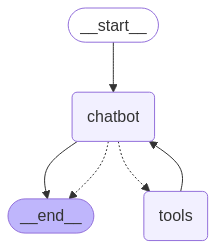

In [23]:
graph

Check the current state as before to confirm that the checkpoint reflects the manual update.

In [24]:
snapshot = graph.get_state(config)

for message in snapshot.values['messages']:
    message.pretty_print()

================================ Human Message =================================

Vui lòng tìm hiểu và cập nhật thông tin giá vàng mới nhất.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (114c7bba-7d2a-4950-8136-8786ea77afca)
 Call ID: 114c7bba-7d2a-4950-8136-8786ea77afca
  Args:
    query: giá vàng mới nhất
================================= Tool Message =================================

[Modified web search result] 
Đồng đôla mạnh lên và hoạt động bán chốt lời khiến giá vàng thế giới mất hơn 20 USD phiên cuối tuần.

Chốt phiên giao dịch 21/3, giá vàng thế giới giao ngay giảm 20 USD xuống 3.023 USD một ounce. Trong phiên, giá có thời điểm về 2.996 USD - thấp nhất 1 tuần qua.

Thị trường đi xuống do đồng đôla mạnh lên và nhà đầu tư bán chốt lời, bất chấp căng thẳng kinh tế - chính trị vẫn tiếp diễn. Khả năng Cục Dự trữ liên bang Mỹ (Fed) giảm lãi suất năm nay cũng giúp vàng ghi nhận tuần tăng thứ 3 liên tiếp, v

In [26]:
snapshot.next

()

## Update the message state after an interrupt – continue the process.

- Sửa đổi **truy vấn tìm kiếm** trong công cụ `TavilySearch`

Lần này, ngắt trước khi chuyển sang nút tiếp theo và cập nhật trạng thái, sau đó tiếp tục quy trình.

Đầu tiên, tạo một `thread_id` mới.

Ở đây, chúng ta sử dụng hàm `generate_random_hash` để tạo giá trị hash ngẫu nhiên.


In [27]:
import random
def generate_random_hash():
    return f"{random.randint(0, 0xffffff):06x}"

In [29]:
generate_random_hash()

'063bc6'

In [32]:
from langchain_core.runnables import RunnableConfig
thread_id = generate_random_hash()
print(f"{thread_id=}")

question = "I want to learn about LangGraph. Can you recommend useful materials?"

input = State(messages=[('user', question)])

# Create a new config
config = RunnableConfig(configurable={"thread_id": thread_id})

events = graph.stream(
    input=input,
    config=config,
    interrupt_before=['tools'],
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

thread_id='4f191a'
================================ Human Message =================================

I want to learn about LangGraph. Can you recommend useful materials?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (74d3f308-a6d5-498b-bc55-6d949681d6dc)
 Call ID: 74d3f308-a6d5-498b-bc55-6d949681d6dc
  Args:
    query: LangGraph overview and resources


Next, let's update the tool call for the agent. 

First, get the `Message ID`. 

In [33]:
config_copy = config.copy()

In [35]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values['messages'][-1]

In [36]:
existing_message.id

'run-606b9603-b5c7-4d8b-9a0f-952d8fcc3b31-0'

In [38]:
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (74d3f308-a6d5-498b-bc55-6d949681d6dc)
 Call ID: 74d3f308-a6d5-498b-bc55-6d949681d6dc
  Args:
    query: LangGraph overview and resources


In [41]:
import json

# Custom function to serialize non-JSON serializable objects
def custom_serializer(obj):
    if hasattr(obj, "__dict__"):
        return obj.__dict__
    elif isinstance(obj, (list, tuple)):
        return [custom_serializer(item) for item in obj]
    return str(obj)


# Custom function to print the snapshot
def pretty_print_snapshot(snapshot):
    try:
        snapshot_json = json.dumps(
            snapshot, indent=4, ensure_ascii=False, default=custom_serializer
        )
        print(snapshot_json)
    except Exception as e:
        print(f"Error formatting snapshot: {e}")

In [42]:
pretty_print_snapshot(existing_message)

{
    "content": "",
    "additional_kwargs": {},
    "response_metadata": {
        "model": "qwen2.5:7b",
        "created_at": "2025-03-24T02:09:05.688540349Z",
        "done": true,
        "done_reason": "stop",
        "total_duration": 31819672532,
        "load_duration": 2484407274,
        "prompt_eval_count": 201,
        "prompt_eval_duration": 14568000000,
        "eval_count": 83,
        "eval_duration": 14760000000,
        "message": {
            "role": "assistant",
            "content": "",
            "images": null,
            "tool_calls": null
        }
    },
    "type": "ai",
    "name": null,
    "id": "run-606b9603-b5c7-4d8b-9a0f-952d8fcc3b31-0",
    "example": false,
    "tool_calls": [
        {
            "name": "tavily_search_results_json",
            "args": {
                "query": "LangGraph overview and resources"
            },
            "id": "74d3f308-a6d5-498b-bc55-6d949681d6dc",
            "type": "tool_call"
        }
    ],
    "inva

Hãy cập nhật `query` trong `args`.

Sao chép `existing_message` và tạo một lệnh gọi công cụ mới `new_tool_call`.

Vì chúng ta đã sử dụng phương thức `copy()`, tất cả các giá trị thuộc tính đều được sao chép.

Sau đó, nhập **truy vấn tìm kiếm** mong muốn vào tham số `query`.

**Quan trọng**

- `id` sử dụng cùng `id` với tin nhắn hiện có. (Nếu `id` thay đổi, bộ giảm tin nhắn sẽ không cập nhật tin nhắn mà thay vào đó sẽ thêm nó.)


In [43]:
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call

{'name': 'tavily_search_results_json',
 'args': {'query': 'LangGraph overview and resources'},
 'id': '74d3f308-a6d5-498b-bc55-6d949681d6dc',
 'type': 'tool_call'}

In [44]:
# Update the query parameter
new_tool_call["args"] = {"query": "LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial"}
new_tool_call

{'name': 'tavily_search_results_json',
 'args': {'query': 'LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial'},
 'id': '74d3f308-a6d5-498b-bc55-6d949681d6dc',
 'type': 'tool_call'}

In [45]:
# Create a new AIMessage
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! ID is a method to replace the message instead of adding it to the state.
    id=existing_message.id,
)

print(new_message.id)

# Print the modified message
new_message.pretty_print()

run-606b9603-b5c7-4d8b-9a0f-952d8fcc3b31-0
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (74d3f308-a6d5-498b-bc55-6d949681d6dc)
 Call ID: 74d3f308-a6d5-498b-bc55-6d949681d6dc
  Args:
    query: LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial


In [46]:
# Print the updated tool call
print(new_message.tool_calls[0])

# Print the message ID
print("\nMessage ID", new_message.id)

# Update the state
graph.update_state(config, {"messages": [new_message]})

{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial'}, 'id': '74d3f308-a6d5-498b-bc55-6d949681d6dc', 'type': 'tool_call'}

Message ID run-606b9603-b5c7-4d8b-9a0f-952d8fcc3b31-0


{'configurable': {'thread_id': '4f191a',
  'checkpoint_ns': '',
  'checkpoint_id': '1f008572-fe62-66aa-8002-4d564353c1aa'}}

In [47]:
# Get the tool call of the last message
graph.get_state(config).values["messages"][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial'},
  'id': '74d3f308-a6d5-498b-bc55-6d949681d6dc',
  'type': 'tool_call'}]

In [48]:
# Receive events from the graph stream
events = graph.stream(None, config, stream_mode="values")

# Process each event
for event in events:
    # If the message is included in the event
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (74d3f308-a6d5-498b-bc55-6d949681d6dc)
 Call ID: 74d3f308-a6d5-498b-bc55-6d949681d6dc
  Args:
    query: LangGraph site:langchain-opentutorial.gitbook.io/langchain-opentutorial
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Agent Simulation | LangChain OpenTutorial", "url": "https://langchain-opentutorial.gitbook.io/langchain-opentutorial/17-langgraph/03-use-cases/01-langgraph-agent-simulation", "content": "Define State\n\nDefine Roles : Agent and Customer\n\nDefine Agent Simulation\n\nDefine Graphs\n\nStart the Simulation\n\nReferences\n\nLangChain\n\nEnvironment Setup\n\nSetting up your environment is the first step. See the Environment Setup guide for more details.\n\n[Note]\n\nThe langchain-opentutorial is a package of easy-to-use environment setup guidance, useful function

In [49]:
# Create an event stream
events = graph.stream(
    {
        "messages": (
            "user",
            "Please provide a kind and detailed answer in Vietnamese about what I have learned so far! Be sure to include the sources!",
        )
    },
    config,
    stream_mode="values",
)

# Process message events
for event in events:
    if "messages" in event:
        # Print the last message
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Please provide a kind and detailed answer in Vietnamese about what I have learned so far! Be sure to include the sources!
================================== Ai Message ==================================

Dựa trên thông tin bạn đã cung cấp, tôi sẽ viết một câu trả lời chi tiết và thân thiện bằng tiếng Việt về những gì bạn đã học được. Tôi cũng sẽ đề cập đến các nguồn tham khảo.

### Những Gì Bạn Đã Học Được

Bạn đã học cách xây dựng một chatbot đơn giản sử dụng LangGraph theo hướng dẫn từ tài liệu của LangGraph. Dưới đây là một số điểm chính mà bạn đã nắm vững:

1. **Môi Trường Xây Dựng**: Bạn đã biết cách cài đặt môi trường phát triển cần thiết, bao gồm việc thiết lập API keys.

2. **Định Nghĩa Trạng Thái (State)**: Bạn đã học cách sử dụng `TypedDict` trong Python để định nghĩa trạng thái của chatbot, theo dõi các tin nhắn qua quá trình trò chuyện.

3. **Tạo Nút (Nodes)**: Bạn đã hiểu rằng nút trong LangG

In [50]:
graph.get_state(config).values["messages"][-1].pretty_print()

================================== Ai Message ==================================

Dựa trên thông tin bạn đã cung cấp, tôi sẽ viết một câu trả lời chi tiết và thân thiện bằng tiếng Việt về những gì bạn đã học được. Tôi cũng sẽ đề cập đến các nguồn tham khảo.

### Những Gì Bạn Đã Học Được

Bạn đã học cách xây dựng một chatbot đơn giản sử dụng LangGraph theo hướng dẫn từ tài liệu của LangGraph. Dưới đây là một số điểm chính mà bạn đã nắm vững:

1. **Môi Trường Xây Dựng**: Bạn đã biết cách cài đặt môi trường phát triển cần thiết, bao gồm việc thiết lập API keys.

2. **Định Nghĩa Trạng Thái (State)**: Bạn đã học cách sử dụng `TypedDict` trong Python để định nghĩa trạng thái của chatbot, theo dõi các tin nhắn qua quá trình trò chuyện.

3. **Tạo Nút (Nodes)**: Bạn đã hiểu rằng nút trong LangGraph thường được thực hiện dưới dạng các hàm Python thông thường và đại diện cho các đơn vị công việc riêng lẻ.

4. **Xây Dựng Và Thêm Các Nút vào Đồ Thị**: Bạn đã biết cách tạo một đồ thị và bao gồm các 

## Modify the result of the past snapshot and replay

Lần này, chúng ta sẽ xem xét cách sửa đổi kết quả của snapshot quá khứ và phát lại.

Kiểm tra snapshot quá khứ và quay lại một nút cụ thể, sau đó **sửa đổi trạng thái và tiếp tục từ nút đó**.

Điều này được gọi là Phát lại (Replay).

Đầu tiên, lấy trạng thái của snapshot quá khứ.


In [51]:
to_replay_state = None

# Get the state history
for state in graph.get_state_history(config):

    messages = state.values["messages"]

    if len(messages) > 0:
        print(state.values["messages"][-1].id)
        # Print the number of messages and the next state
        print("the number of chat messages: ", len(state.values["messages"]), "next node: ", state.next)
        print("-" * 80)
        # Select the specific state based on the number of chat messages
        if len(state.values["messages"]) == 2:
            # Select the specific message ID
            to_replay_state = state

run-cee30d3f-3ef9-4ec0-be67-bb777914d9a8-0
the number of chat messages:  6 next node:  ()
--------------------------------------------------------------------------------
6c415d31-12c1-4aea-9fc0-bcbfaf4ce178
the number of chat messages:  5 next node:  ('chatbot',)
--------------------------------------------------------------------------------
run-e02a1b86-2993-4ca8-a59c-c9afd52cfc43-0
the number of chat messages:  4 next node:  ('__start__',)
--------------------------------------------------------------------------------
run-e02a1b86-2993-4ca8-a59c-c9afd52cfc43-0
the number of chat messages:  4 next node:  ()
--------------------------------------------------------------------------------
1dbf605a-822d-4125-8f0a-06208f4c7c52
the number of chat messages:  3 next node:  ('chatbot',)
--------------------------------------------------------------------------------
run-606b9603-b5c7-4d8b-9a0f-952d8fcc3b31-0
the number of chat messages:  2 next node:  ('tools',)
---------------------------

In [52]:
from utils.messages import display_message_tree

# Get the selected message
existing_message = to_replay_state.values["messages"][-1]

# Print the message tree
display_message_tree(existing_message)

    content: ""
    additional_kwargs: {}
    response_metadata:
        model: "qwen2.5:7b"
        created_at: "2025-03-24T02:09:05.688540349Z"
        done: True
        done_reason: "stop"
        total_duration: 31819672532
        load_duration: 2484407274
        prompt_eval_count: 201
        prompt_eval_duration: 14568000000
        eval_count: 83
        eval_duration: 14760000000
        message: {"role": "assistant", "content": "", "images": None, "tool_calls": None}
    type: "ai"
    name: None
    id: "run-606b9603-b5c7-4d8b-9a0f-952d8fcc3b31-0"
    example: False
    tool_calls:
        index [0]
            name: "tavily_search_results_json"
            args: {"query": "LangGraph overview and resources"}
            id: "74d3f308-a6d5-498b-bc55-6d949681d6dc"
            type: "tool_call"
    invalid_tool_calls:
    usage_metadata: {"input_tokens": 201, "output_tokens": 83, "total_tokens": 284}


In [53]:
tool_call = existing_message.tool_calls[0].copy()
tool_call["args"] = {"query": "LangGraph human-in-the-loop workflow site:reddit.com"}
tool_call

{'name': 'tavily_search_results_json',
 'args': {'query': 'LangGraph human-in-the-loop workflow site:reddit.com'},
 'id': '74d3f308-a6d5-498b-bc55-6d949681d6dc',
 'type': 'tool_call'}

In [54]:
# Create an updated AIMessage
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[tool_call],
    # Important! ID is a method to replace the message instead of adding it to the state.
    id=existing_message.id,
)

# Print the updated message
new_message.tool_calls[0]["args"]

{'query': 'LangGraph human-in-the-loop workflow site:reddit.com'}

In [55]:
# Check the message before the update
graph.get_state(to_replay_state.config).values["messages"][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph overview and resources'},
  'id': '74d3f308-a6d5-498b-bc55-6d949681d6dc',
  'type': 'tool_call'}]

In [56]:
# Update the state
updated_state = graph.update_state(
    to_replay_state.config,
    {"messages": [new_message]},
)
updated_state

{'configurable': {'thread_id': '4f191a',
  'checkpoint_ns': '',
  'checkpoint_id': '1f008599-bdce-6b5d-8002-a5b09dd686ba'}}

In [57]:
# Pass the `updated_state` to the config. This involves passing an arbitrarily updated state.
for event in graph.stream(None, updated_state, stream_mode="values"):
    # If the message is included in the event
    if "messages" in event:
        # display the last message
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (74d3f308-a6d5-498b-bc55-6d949681d6dc)
 Call ID: 74d3f308-a6d5-498b-bc55-6d949681d6dc
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Human In The Loop In Langgraph : r/LangChain", "url": "https://www.reddit.com/r/LangChain/comments/1ea3p2i/human_in_the_loop_in_langgraph/", "content": "Members Online\n•\nDirect-Station9581\nADMIN MOD\nHuman In The Loop In Langgraph\nfrom langgraph_state import GraphState\nfrom langgraph.graph import END, StateGraph\nfrom langgraph.checkpoint.memory import MemorySaver\nfrom nodes import build_strategy, human_feedback, decision_node, rag_node, database_search, web_search_node, sql_search_node, state_printer\nfrom edges import rag_database_websearch_sqlseqrch, strategy_decision\nworkflow

Output the final result.

The `config` used here is not to retrieve the final state but serves as the initial `config` to obtain the final state.

In [58]:
# Output the final result
for msg in graph.get_state(config).values["messages"]:
    msg.pretty_print()

================================ Human Message =================================

I want to learn about LangGraph. Can you recommend useful materials?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (74d3f308-a6d5-498b-bc55-6d949681d6dc)
 Call ID: 74d3f308-a6d5-498b-bc55-6d949681d6dc
  Args:
    query: LangGraph human-in-the-loop workflow site:reddit.com
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Human In The Loop In Langgraph : r/LangChain", "url": "https://www.reddit.com/r/LangChain/comments/1ea3p2i/human_in_the_loop_in_langgraph/", "content": "Members Online\n•\nDirect-Station9581\nADMIN MOD\nHuman In The Loop In Langgraph\nfrom langgraph_state import GraphState\nfrom langgraph.graph import END, StateGraph\nfrom langgraph.checkpoint.memory import MemorySaver\nfrom nodes import build_strategy, human_feedback, decision_node, rag_